In [0]:
# from google.colab import drive
# drive.mount('/content/drive')

# Enhancing Image Resolution using Autoencoders

## Task 1: Project Overview and Import Libraries

In [0]:
import os
import re
from scipy import ndimage, misc
from skimage.transform import resize, rescale
from matplotlib import pyplot
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(0)

from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.layers import Conv2DTranspose, UpSampling2D, add
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
import tensorflow as tf
print(tf.__version__)

from google.colab import files

2.1.0


## Task 2: Build the Encoder

In [0]:
input_img = Input(shape=(256, 256, 3))
# To fetch features from the input image
l1 = Conv2D(64, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(input_img)

# 1 input layer - 2 convolution layer - 1 max pooling layer
# Extracting features from a smaller image (i.e. after downscaling a picture to smaller dimension by a scale factor of 2) - applied on the output l1
l2 = Conv2D(64, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l1)

# Max pooling layer
l3 = MaxPooling2D(padding='same')(l2)

# Add more convolution layer to learn more features
l4 = Conv2D(128, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l3)
l5 = Conv2D(128, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l4)
l6 = MaxPooling2D(padding='same')(l5)
l7 = Conv2D(256, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l6)
encoder = Model(input_img, l7)

In [0]:
encoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 256, 256, 64)      1792      
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 256, 256, 64)      36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 128, 128, 128)     147584    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 64, 64, 128)       0   

## Task 3: Build the Decoder to Complete the Network

In [0]:
input_img = Input(shape=(256, 256, 3))
# To fetch features from the input image
l1 = Conv2D(64, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(input_img)

# 1 input layer - 2 convolution layer - 1 max pooling layer
# Extracting features from a smaller image (i.e. after downscaling a picture to smaller dimension by a scale factor of 2) - applied on the output l1
l2 = Conv2D(64, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l1)

# Max pooling layer
l3 = MaxPooling2D(padding='same')(l2)

# Add more convolution layer to learn more features
l4 = Conv2D(128, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l3)
l5 = Conv2D(128, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l4)
l6 = MaxPooling2D(padding='same')(l5)
l7 = Conv2D(256, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l6)

In [0]:
# Decoder - to take input representation and scale it by 2X

l8 = UpSampling2D()(l7)
l9 = Conv2D(128, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l8)
l10 = Conv2D(128, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l9)
l11 = add([l5, l10])
l12 = UpSampling2D()(l11)
l13 = Conv2D(64, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l12)
l14 = Conv2D(64, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l13)
l15 = add([l14, l2])

decoded = Conv2D(3, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l15)
autoencoder = Model(input_img, decoded)
autoencoder.summary()




Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 256, 256, 64) 1792        input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 256, 256, 64) 36928       conv2d_20[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)  (None, 128, 128, 64) 0           conv2d_21[0][0]                  
____________________________________________________________________________________________

In [0]:
autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')

## Task 4: Create Dataset and Specify Training Routine

In [0]:
def train_batches(just_load_dataset=False):

    batches = 30 #256 

    batch = 0 
    batch_nb = 0 
    max_batches = -1 
    
    ep = 4 

    images = []
    x_train_n = []
    x_train_down = []
    
    x_train_n2 = [] 
    x_train_down2 = []
    
    # Path of the dataset - to be changed as per local system location
    for root, dirnames, filenames in os.walk("/content/drive/My Drive/Colab Notebooks/project_image_resolution_enhancement/data"):
        for filename in filenames:
            if re.search("\.(jpg|jpeg|JPEG|png|bmp|tiff)$", filename):
                if batch_nb == max_batches: 
                    return x_train_n2, x_train_down2
                filepath = os.path.join(root, filename)
                image = pyplot.imread(filepath)
                if len(image.shape) > 2:
                        
                    image_resized = resize(image, (256, 256))
                    x_train_n.append(image_resized)
                    x_train_down.append(rescale(rescale(image_resized, 0.5), 2.0))
                    batch += 1
                    if batch == batches:
                        batch_nb += 1

                        x_train_n2 = np.array(x_train_n)
                        x_train_down2 = np.array(x_train_down)
                        
                        if just_load_dataset:
                            return x_train_n2, x_train_down2
                        
                        print('Training batch', batch_nb, '(', batches, ')')

                        autoencoder.fit(x_train_down2, x_train_n2,
                            epochs=ep,
                            batch_size=10,
                            shuffle=True,
                            validation_split=0.15)
                    
                        x_train_n = []
                        x_train_down = []
                    
                        batch = 0

    return x_train_n2, x_train_down2

## Task 5: Load the Dataset and Pre-trained Model

In [0]:
x_train_n, x_train_down = train_batches(just_load_dataset=True)

In [0]:
len(x_train_n)

30

In [0]:
len(x_train_down)

30

In [0]:
autoencoder.load_weights('/content/drive/My Drive/Colab Notebooks/project_image_resolution_enhancement/sr.img_net.mse.final_model5.no_patch.weights.best.hdf5')

## Task 6: Model Predictions and Visualizing the Results

In [0]:
encoder.load_weights('/content/drive/My Drive/Colab Notebooks/project_image_resolution_enhancement/encoder_weights.hdf5')

In [0]:
encoded_imgs = encoder.predict(x_train_down)

In [0]:
encoded_imgs.shape

(30, 64, 64, 256)

In [0]:
# High resolution image
sr1 = np.clip(autoencoder.predict(x_train_down), 0.0, 1.0)

In [0]:
# Image index in the dataset
image_index = 28 # np.random.randint(0, 256)

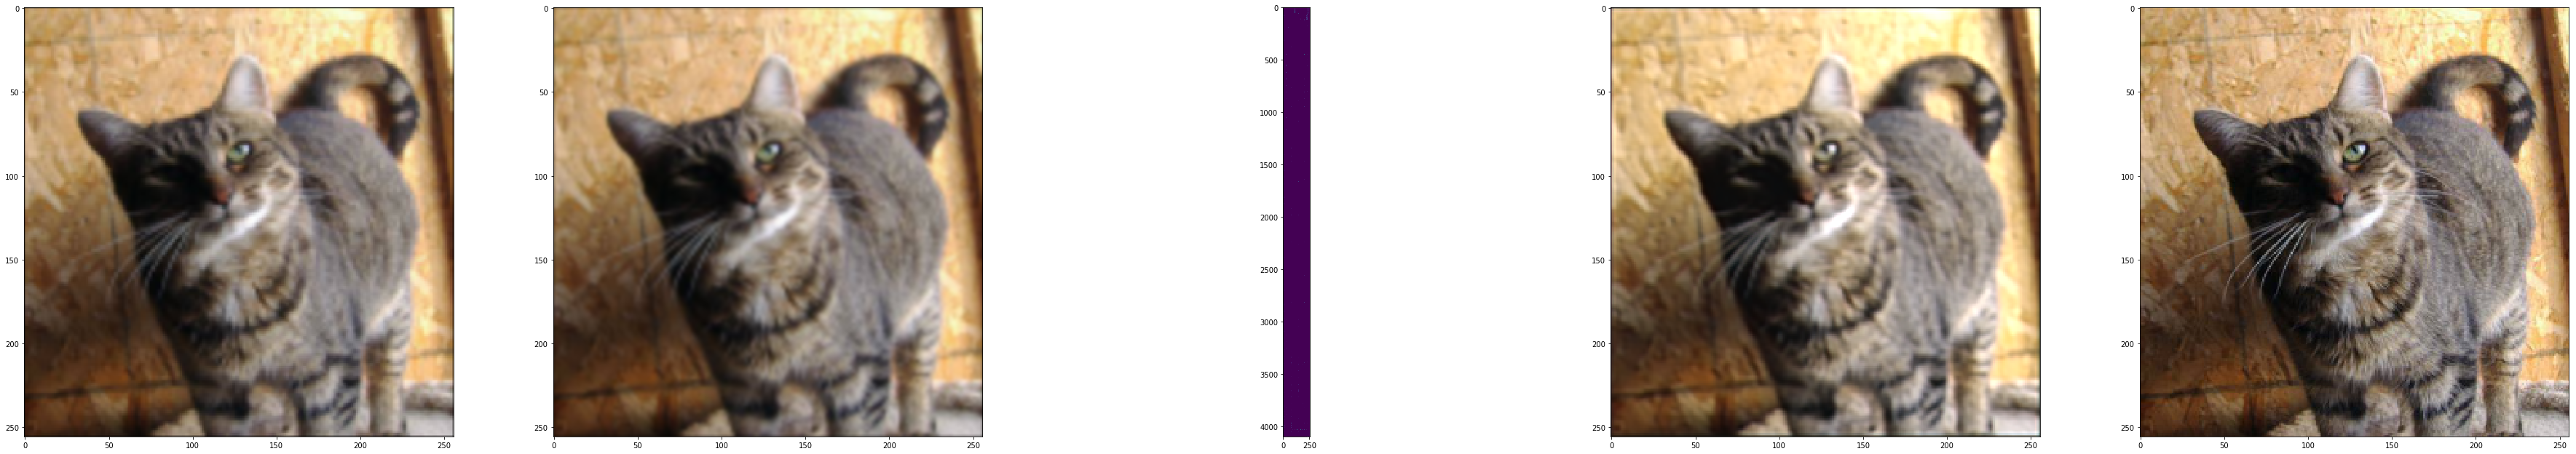

In [0]:
# Plot original low resolution image
plt.figure(figsize=(128, 128))
i = 1
ax = plt.subplot(10, 10, i)
plt.imshow(x_train_down[image_index])
i += 1

# Plot image enhanced using traditional methods
ax = plt.subplot(10, 10, i)
plt.imshow(x_train_down[image_index], interpolation='bicubic')
i += 1

# Reshaped encoded image
ax = plt.subplot(10, 10, i)
plt.imshow(encoded_imgs[image_index].reshape((64*64, 256)))
i += 1

# Plotting high resolution image using autoencoder
ax = plt.subplot(10, 10, i)
plt.imshow(sr1[image_index])
i += 1

# High resolution ground truth
ax = plt.subplot(10, 10, i)
plt.imshow(x_train_n[image_index])

# plt.savefig('high_resolution_test_image.jpg')
# files.download('high_resolution_test_image.jpg')

plt.show()

# Image 1 - original low resolution image
# Image 2 - image enhanced using traditional methods
# Image 3 - high resolution image using autoencoder
# Image 4 -  High resolution ground truth image

In [0]:
 

# Plot original low resolution image
# plt.figure(figsize=(128, 128))
# i = 1

# High resolution ground truth
# plt.imshow(x_train_n[image_index])

# plt.savefig('high_resolution_test_image.jpg')
# files.download('high_resolution_test_image.jpg')
